# Alcohol Dehydration
This notebook uses the average reaction vector method to perform three tasks for alcohol dehydration as follow:
* Calculate the average and std dev of angle and magnitude of each vectors of reaction path,
* Calculate the difference between the predicted vectors and the actual vectors,
* Perform a deeper analysis of the molecules generated within 1 std dev of the average vector.

### First  import the packge and load the dataset:

In [1]:
import math
import sys
sys.path.append('../')
from fcts import array_in_nd_array, remove_space, r2pcorr,struc2mol
import numpy as np
import pandas as pd
import darkchem
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
get_ipython().run_line_magic('matplotlib', 'inline')
from sklearn.linear_model import LinearRegression
from rdkit import Chem
from rdkit.Chem.Draw import MolToImage
# plotting stuff
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import SVG, display
%config InlineBackend.figure_format = 'retina'
import statistics

Using TensorFlow backend.


In [2]:
# Load model
model = darkchem.utils.load_model('../../../DarKnight_File/Final Trained DarkChem Network Weights/N7b_[M+H]/')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [3]:
# load training set
x = np.load('../../../DarKnight_File/Training Data - Molecules/combined_[M+H]_smiles.npy')

### Then, define several functions that will be used:

In [4]:
# Define a fuction that can check the existance of our input molecules
def array_in_nd_array(test, array):
    """
    Checks whether or not a test 1D array is contained within a full N-D array.
    Returns True if the test array is equal to any of the dimensions of the N-D array.
    Returns False if the test array does not match any dimension of the N-D array.
    """
    return any(np.array_equal(x, test) for x in array)

In [5]:
# Define a fuction that transfer input molecules into vectors
def smi_vec_verify(dic):
    
    """Takes a dictionary with reactants and products.
    Creates vectorized representations and appends to dictionary
    as 'rvec' and 'pvec'.
    Checks that both vector types are contained within the loaded
    dataset x.
    
    """
    assert type(dic) == dict, 'Input must be a dictionary'
    assert len(dic) == 2, 'Input dictionary must contain 2 items (reactants, products)'
    
    dic['rvec'] = [darkchem.utils.struct2vec(reactant).astype(np.int16) for reactant in dic['reactants']]
    dic['pvec'] = [darkchem.utils.struct2vec(product).astype(np.int16) for product in dic['products']]
    
    is_in_testset = [[array_in_nd_array(item, x) for item in key] for key in dic.values()]
    
    print(f"Is each reactant contained in the DarkChem training set?: {is_in_testset[2]}")
    print(f"Is each product contained in the DarkChem training set?: {is_in_testset[3]}")
    
    return dic

In [6]:
# Define a function that generate the latent space and calulate the average reaction vector
def vec_latent_rxn_vector(dic):
    
    """Takes a dictionary with reaction vectors and product vectors.
    Converts vectorized representations to latent space vector
    representations and appends to dictionary as 'rlat' and 'plat'.
    
    Calculates reaction vector (subtraction of reactant latent space
    vector from product latent space vector.
    
    Displays Pearson correlation matrix for all reaction vectors.
    
    Averages all reaction vectors and returns dic, avgvec.
    
    """
    dic['rlat'] = model.encoder.predict(np.array(dic['rvec']))
    dic['plat'] = model.encoder.predict(np.array(dic['pvec']))
    
    dic['rxnvector'] = [dic['plat'][i] - dic['rlat'][i] for i in range(len(dic['plat']))]
    
    print(pd.DataFrame(np.corrcoef(dic['rxnvector']).view(type=np.matrix)))
    
    avgvec = np.array(dic['rxnvector']).sum(axis=0) / len(dic['rxnvector'])
    
    return dic, avgvec

In [7]:
# Define a function that apply the reaction vector to an input molecule
def apply_rxn_vector(smistr, rxnvec, nummols=10, savefilename=False):
    
    """Takes a SMILES string representation for a molecule.
    Adds input vector (e.g. avgvec output from vec_latent_rxn_vector)
    and shows chemical structures for the top 10 highest-probability
    product predictions (can be altered with nummols)
    
    """
    testvec = darkchem.utils.struct2vec(smistr).astype(np.int16)
    array_in_nd_array(testvec, x)
    
    testlat = model.encoder.predict(np.array(testvec.reshape(-1,100)))
    
    testprod = testlat + rxnvec
    testpvec = model.decoder.predict(testprod)
    testprods = darkchem.utils.beamsearch(testpvec, k=nummols)
    
    predictions = {}
    
    predictions['predprod'] = [darkchem.utils.vec2struct(i) for i in testprods[0]]
    predictions['predprodmol'] = [Chem.MolFromSmiles(predictions['predprod'][i])
                                  for i in range(len(predictions['predprod']))]
    
    if type(savefilename) == str:
        img = Chem.Draw.MolsToGridImage(predictions['predprodmol'],
                                        molsPerRow=5, subImgSize=(200, 200))
        img.save(f'./{savefilename}.png')
    
    return Chem.Draw.MolsToGridImage(predictions['predprodmol'],
                                     molsPerRow=5, subImgSize=(200, 200))

### And we load several alcohol dehydration reactions and put them into darkchem:

In [8]:
# load training data of Alcohol_Dehydration
data = pd.read_excel('../../database/Alcohol_Dehydration.xlsx')

#remove the redundant space in the smiles string
data = remove_space(data)

..\fcts.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data['Reactants'][i] = data['Reactants'][i].replace(' ','')
..\fcts.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data['Products'][i] = data['Products'][i].replace(' ','')


In [9]:
# Transform reactants and products into dictionary
red = {'reactants': data['Reactants'],
       'products': data['Products']}

In [10]:
# Transform the molecules above into vector and check the existance in the training set
red = smi_vec_verify(red)

Is each reactant contained in the DarkChem training set?: [False, False, False, False, True, True, True, True, True, True, True, True, True, True, True, True, True]
Is each product contained in the DarkChem training set?: [True, True, True, True, True, False, True, True, True, True, True, True, False, True, True, True, False]


In [11]:
# Generate the latent space
red, redvec = vec_latent_rxn_vector(red)

          0         1         2         3         4         5         6   \
0   1.000000  0.576913  0.502995  0.412270  0.345671  0.330784  0.343978   
1   0.576913  1.000000  0.916099  0.672300  0.863099  0.778659  0.765092   
2   0.502995  0.916099  1.000000  0.860326  0.822517  0.933915  0.909939   
3   0.412270  0.672300  0.860326  1.000000  0.574867  0.826805  0.828623   
4   0.345671  0.863099  0.822517  0.574867  1.000000  0.856135  0.790154   
5   0.330784  0.778659  0.933915  0.826805  0.856135  1.000000  0.933646   
6   0.343978  0.765092  0.909939  0.828623  0.790154  0.933646  1.000000   
7   0.358882  0.396801  0.327827  0.115406  0.556524  0.382607  0.500829   
8   0.269018  0.482008  0.680800  0.885835  0.466856  0.695865  0.741895   
9   0.478637  0.659520  0.681790  0.549435  0.598615  0.627557  0.784550   
10  0.276164  0.534664  0.801830  0.825773  0.494940  0.848436  0.813047   
11  0.313349  0.605863  0.789417  0.799214  0.544088  0.779152  0.932597   
12  0.276825

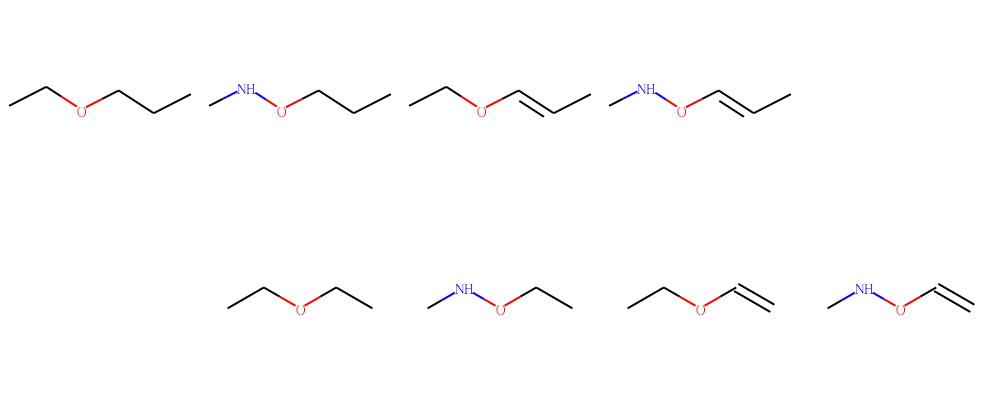

In [12]:
# Predict a certain molecule
ethanol = 'CCO'
apply_rxn_vector(ethanol, redvec, savefilename='Alcohol_Dehydration')

### Perform the first task: 
* Calculate the average and std dev of angle and magnitude of each vectors of reaction path

In [16]:
# Put those vectors into DataFrame
rct = pd.DataFrame(red['rlat'])
prod = pd.DataFrame(red['plat'])

In [20]:
# Calcualte the lengh of each reaction path
d1 = []
for i in range(16):
    s1 = 0
    for j in range(128):
        s1 += (rct.loc[i][j] - prod.loc[i][j])**2
    ds1 = np.sqrt(s1)
    d1.append(ds1)
    
# Calculate the average length of the Alcohol Dehydration reaction path
sum1 = 0
for num in d1:
    sum1 = sum1 + num
    average1 = sum1 / len(d1)

# Calculate the std length of the Alcohol Dehydration reaction path
std1 = statistics.stdev(d1)

In [21]:
# Calculate the dot product of each reaction
d2 = []
for i in range(16):
    s2 = 0
    for j in range(128):
        s2 += (rct.loc[i][j] * prod.loc[i][j])
    #ds = np.sqrt(s)
    d2.append(s2)


# Calculate the product of each reactant and product
d3 = []
for i in range(16):
    s3 = 0
    s4 = 0
    for j in range(128):
        s3 += (rct.loc[i][j])**2
        s4 += (prod.loc[i][j])**2
    dd = np.sqrt(s3)
    dx = np.sqrt(s4)
    xx = dd*dx
    d3.append(xx)

# Insert the formula of Cosine theorem
a1 = []
for i in range(16):
    cos = d2[i]/d3[i]  #this is the value of cos(sita)
    angle = math.acos(cos)  #this is the value of sita
    a1.append(angle)

# Calculate the average angle of the Alcohol Dehydration reaction path    
sum2 = 0
for num in a1:
    sum2 = sum2 +num
    average2 = sum2 / len(a1)
    
# Calculate the std angle of the Alcohol Dehydration reaction path
std2 = statistics.stdev(a1)

In [22]:
df1 = {'d1':d1, 'average1':average1, 'std1':std1, 'a1':a1, 'average2':average2, 'std2':std2}
df1 = pd.DataFrame(df1)
df1.columns = ['length', 'average', 'std', 'angle', 'average', 'std']
print('The length and the angle of each reaction in training set :')
df1

The length and the angle of each reaction in training set :


,length,average,std,angle,average,std
0,1.269720,2.29735,0.777599,0.114450,0.184021,0.068943
1,1.636268,2.29735,0.777599,0.129986,0.184021,0.068943
2,2.443346,2.29735,0.777599,0.172231,0.184021,0.068943
3,2.699125,2.29735,0.777599,0.199159,0.184021,0.068943
4,1.128713,2.29735,0.777599,0.095064,0.184021,0.068943
5,1.878527,2.29735,0.777599,0.131538,0.184021,0.068943
6,2.818934,2.29735,0.777599,0.201525,0.184021,0.068943
7,2.297741,2.29735,0.777599,0.212909,0.184021,0.068943
8,2.407054,2.29735,0.777599,0.176970,0.184021,0.068943
9,3.231560,2.29735,0.777599,0.250068,0.184021,0.068943


### Perform the second task:
* Calculate the difference between the predicted vectors and the actual vectors

In [23]:
# Identify the predicted product in the latent space
smistr = 'CCO'
rxnvec = redvec
nummols = 10

testvec = darkchem.utils.struct2vec(smistr).astype(np.int16)
array_in_nd_array(testvec, x)
    
testlat = model.encoder.predict(np.array(testvec.reshape(-1,100)))
    
testprod = testlat + rxnvec
testpvec = model.decoder.predict(testprod)
testprods = darkchem.utils.beamsearch(testpvec, k=nummols)
    
predictions = {}
    
predictions['predprod'] = [darkchem.utils.vec2struct(i) for i in testprods[0]]

In [24]:
# Locate the predicted product in the latent space
reactant = {'reactants':['CCO','CCO','CCO','CCO','CCO','CCO','CCO','CCO','CCO','CCO']}
actualprod = {'products':['CCOCC','CCOCC','CCOCC','CCOCC','CCOCC','CCOCC','CCOCC','CCOCC','CCOCC','CCOCC']}

reactantvect = {}
actualprodvect = {}
predictionsvect = {}

reactantvect['reactant'] = [darkchem.utils.struct2vec(reactant).astype(np.int16) for reactant in reactant['reactants']]
actualprodvect['actualprod'] = [darkchem.utils.struct2vec(product).astype(np.int16) for product in actualprod['products']]
predictionsvect['predprod'] = [darkchem.utils.struct2vec(product).astype(np.int16) for product in predictions['predprod']]

reactantvect['reactantlat'] = model.encoder.predict(np.array(reactantvect['reactant']))
actualprodvect['actualprodlat'] = model.encoder.predict(np.array(actualprodvect['actualprod']))
predictionsvect['predprodlat'] = model.encoder.predict(np.array(predictionsvect['predprod']))

In [25]:
# Put those vectors into DataFrame
rct = pd.DataFrame(reactantvect['reactantlat'])
aprod = pd.DataFrame(actualprodvect['actualprodlat'])
pprod = pd.DataFrame(predictionsvect['predprodlat'])

In [26]:
# Calcualte the lengh between each predicted product and actual product
d4 = []
for i in range(10):
    s5 = 0
    for j in range(128):
        s5 += (pprod.loc[i][j] - aprod.loc[i][j])**2
    ds2 = np.sqrt(s5)
    d4.append(ds2)
    
# Calculate the average lengh between each predicted product and actual product
sum3 = 0
for num in d4:
    sum3 = sum3 +num
    average3 = sum3 / len(d4)

# Calculate the std of length between each predicted product and actual product
std3 = statistics.stdev(d4)

In [27]:
# Calcualte the lengh of the vector for each predicted product
d5 = []
for i in range(10):
    s6 = 0
    for j in range(128):
        s6 += (pprod.loc[i][j] - rct.loc[i][j])**2
    ds3 = np.sqrt(s6)
    d5.append(ds3)
    
# Calculate the average lengh of the vector for each predicted product
sum4 = 0
for num in d5:
    sum4 = sum4 +num
    average4 = sum4 / len(d5)

# Calculate the std of length of the vector for each predicted product
std4 = statistics.stdev(d5)

In [30]:
# Calculate the dot product of each reaction
d6= []
for i in range(10):
    s7 = 0
    for j in range(128):
        s7 += (rct.loc[i][j] * pprod.loc[i][j])
    #ds = np.sqrt(s)
    d6.append(s7)


# Calculate the product of each reactant and product
d7= []
for i in range(10):
    s8 = 0
    s9 = 0
    for j in range(128):
        s8 += (rct.loc[i][j])**2
        s9 += (pprod.loc[i][j])**2
    dd = np.sqrt(s8)
    dx = np.sqrt(s9)
    xx = dd*dx
    d7.append(xx)

# Insert the formula of Cosine theorem
a2 = []
for i in range(10):
    cos = d2[i]/d3[i]  #this is the value of cos(sita)
    angle = math.acos(cos)  #this is the value of sita
    a2.append(angle)

# Calculate the average angle of each predicted Alcohol Dehydration reaction path    
sum5 = 0
for num in a2:
    sum5 = sum5 +num
    average5 = sum5 / len(a2)
    
# Calculate the std angle of each predicted Alcohol Dehydration reaction path
std5 = statistics.stdev(a2)

In [31]:
df2 = {'d4':d4, 'average3':average3, 'std3':std3, 'd5':d5, 'average4':average4, 'std4':std4,'a2':a2, 'average5':average5, 'std5':std5}
df2 = pd.DataFrame(df2)
df2.columns = ['length between each predicted product and actual product', 'average', 'std', 'length of each predicted reaction vector', 'average', 'std', 'angle of each predicted reaction vector', 'average', 'std']
print('The information of predicted reaction vector :')
df2

The information of predicted reaction vector :


,length between each predicted product and actual product,average,std,length of each predicted reaction vector,average,std,angle of each predicted reaction vector,average,std
0,1.149738,1.006854,0.444546,2.443346,1.96789,0.375978,0.114450,0.16839,0.049335
1,1.081474,1.006854,0.444546,2.230340,1.96789,0.375978,0.129986,0.16839,0.049335
2,1.373985,1.006854,0.444546,2.477477,1.96789,0.375978,0.172231,0.16839,0.049335
3,1.410727,1.006854,0.444546,2.410955,1.96789,0.375978,0.199159,0.16839,0.049335
4,1.232006,1.006854,0.444546,1.811045,1.96789,0.375978,0.095064,0.16839,0.049335
5,1.347436,1.006854,0.444546,1.800887,1.96789,0.375978,0.131538,0.16839,0.049335
6,0.000000,1.006854,0.444546,1.636268,1.96789,0.375978,0.201525,0.16839,0.049335
7,0.498640,1.006854,0.444546,1.598143,1.96789,0.375978,0.212909,0.16839,0.049335
8,0.900040,1.006854,0.444546,1.655188,1.96789,0.375978,0.176970,0.16839,0.049335
9,1.074499,1.006854,0.444546,1.615253,1.96789,0.375978,0.250068,0.16839,0.049335


#### The differences bewteen the actual and the predicted reaction vectors:
| Index         |   Length|    Angle| 
|---------------|---------|---------|
|         Actual| 1.269720| 0.114450|
| Predicted(Avg)| 1.967890| 0.168390|
| Predicted(Std)| 0.375978| 0.049335|

### Perform the third task:
* Perform a deeper analysis of the molecules generated within 1 std dev of the average vector